<a href="https://colab.research.google.com/github/umbertogagl97/Tesi/blob/main/DataAug.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Init**

## Import librerie

In [1]:
import tensorflow as tf
import numpy as np

##Def variabili

In [2]:
#Scanner
scanner_name = 'DigitalPersona'

#salvataggio modello
model_save_name = 'VGG19_first_trial'
path_model_save = F"/content/gdrive/My Drive/ModelliCNN/Scanner/{scanner_name}/Keras/{model_save_name}" 

#load dataset training
pathDataset=F'/content/gdrive/MyDrive/Dataset_impronte/training/{scanner_name}'

pathTestset=F'/content/gdrive/MyDrive/Dataset_impronte/test/{scanner_name}'

##Parametri

In [3]:
batch_size=5
num_class=2

##Collegamento google drive

In [4]:
#collegamento google drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


##ImageGenerator

In [ ]:
!pip install imgaug

In [6]:
import imageio
import imgaug as ia
import imgaug.augmenters as iaa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib
%matplotlib inline

#**Dataset**

##Caricamento dataset

In [8]:
train_ds= tf.keras.utils.image_dataset_from_directory(
    pathDataset,
    label_mode='categorical',
    image_size=(224,224)) #effettua il resize delle immagini

Found 2000 files belonging to 2 classes.


##Crop singola immagine

In [14]:
input,label=next(iter(train_ds))

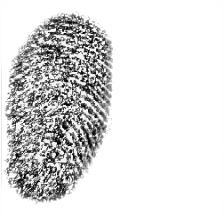

(224, 224, 3)


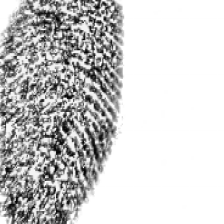

In [33]:
import cv2
from google.colab.patches import cv2_imshow

crop = iaa.Crop(percent=((0,0.2),(0,0.2),(0,0.2),(0,0.2))) # crop image
img=input[0]
img=img.numpy()
cv2_imshow(img)
corp_image=crop.augment_image(input[0])
print(corp_image.shape)
cv2_imshow(corp_image)

##Prova Crop

In [63]:
def crop_fun(img):
  crop = iaa.Crop(percent=((0,0.5),(0,0.5),(0,0.5),(0,0.5))) # crop image
  c_img=crop.augment_image(img)
  return c_img

In [65]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
datagen=ImageDataGenerator(preprocessing_function=crop_fun)


In [54]:
print(input[0].shape)

(224, 224, 3)


In [70]:
gen_flow=datagen.flow(input) #è il dataset da passare a model.fit, dà problemi col batch 

TypeError: ignored

In [67]:
ii=next(gen_flow)

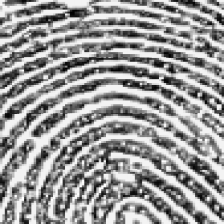

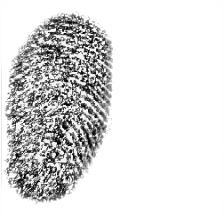

In [69]:
cv2_imshow(ii[0])
cv2_imshow(input[0].numpy())


##nome classi

In [9]:
classes_name=train_ds.class_names
print(classes_name)

['Live', 'Spoof']


##Calcolo dimensioni dataset

In [10]:
import os
list = os.listdir(pathDataset) # dir is your directory path
dim_set=0
for x in list:
  dim_set=dim_set+(len(os.listdir(os.path.join(pathDataset,x))))
print(dim_set)

2000


##Calcolo dimensioni immagini

In [11]:
image_batch, labels_batch = next(iter(train_ds))
im_shape=image_batch[0].shape
del image_batch,labels_batch
print(im_shape)

(224, 224, 3)


#**Creazione modello**

###Load model pre-trained

In [ ]:
#creazione rete usando vgg16 preaddestrata e aggiungendo gli ultimi livelli per adattarla al problema di 10 classi
from tensorflow.keras import applications as applications

#importa rete vgg16 addestrata sul dataset imagenet, esclude gli ultimi livelli e come input pongo dimensioni 96,96,3 
model_conv = applications.VGG19(weights='imagenet', include_top=False, input_shape=(im_shape[0],im_shape[1],im_shape[2]))

# Freeze all the layers (non modifico i pesi dei livelli inferiori)
for layer in model_conv.layers[:]:
    layer.trainable = False

model_conv.summary()    

80150528/80134624 [==============================] - 1s 0us/step
Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
______________________________________________________________

#**Training**
> per riaddestrare eseguire solo questa sezione



##Aggiunta classificatore

In [ ]:
from tensorflow.keras import layers,models,losses,optimizers,applications
import numpy as np

# creo un modello aggiungendo livelli alla rete importata
model = models.Sequential()
# Add the vgg convolutional base model
model.add(model_conv)
# Add new layers
model.add(layers.Flatten())
model.add(layers.Dense(4096, activation='relu'))
model.add(layers.Dense(4096, activation='relu'))
model.add(layers.Dense(num_class, activation='softmax')) #10: numero di valori in uscita (le classi)

#stampa info del modello
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 7, 7, 512)         20024384  
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 4096)              102764544 
_________________________________________________________________
dense_4 (Dense)              (None, 4096)              16781312  
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 8194      
Total params: 139,578,434
Trainable params: 119,554,050
Non-trainable params: 20,024,384
_________________________________________________________________


##Configura parametri modello

In [ ]:
# Configure the model for training (setta i parametri del modello)
model.compile(
        loss=losses.categorical_crossentropy, optimizer=optimizers.SGD(learning_rate=1e-6,momentum=0.9), metrics=["accuracy"]
    )

##Addestramento

In [ ]:
history= model.fit(train_ds,epochs=30,batch_size=5,validation_data=val_ds)

Epoch 1/30
33/50 [==================>...........] - ETA: 3:03 - loss: 1.1321 - accuracy: 0.7008

KeyboardInterrupt: ignored

#**Testing**

In [ ]:
test_ds= tf.keras.utils.image_dataset_from_directory(
    pathTestset,
    label_mode='int',
    image_size=(224,224)) 

Found 2500 files belonging to 2 classes.


In [ ]:
import os
list = os.listdir(pathTestset) # dir is your directory path
dim_tset=0
for x in list:
  dim_tset=dim_tset+(len(os.listdir(os.path.join(pathTestset,x))))
print(dim_tset)

2500


In [ ]:
acc=0
for input,label in test_ds:
  preds=np.argmax(model.predict_on_batch(input),axis=1)
  acc = acc+ np.sum(preds == label.numpy())
acc=acc/dim_tset  
print("Accuracy on test set:", (round(acc,2)*100))

Accuracy on test set: 0.72


#**Salvataggio modello**

In [ ]:
#salva modello su drive
model.save(path_model_save)

INFO:tensorflow:Assets written to: /content/gdrive/My Drive/ModelliCNN/Scanner/DigitalPersona/VGG19_first_trial/assets
